# scRNAseq analysis part 2

#### Outline
HW2 will be posted by tomorrow morning.

Today, we are going to continue where we left off last Thursday. We will cover the following:

- background information on example data
- more on quality control
- normalization
- variable gene selection
- principle component analysis
- predicting cell cycle status
- k-means clustering
- hierarchical clustering
- kNN
- leiden clustering


#### Background
First, let's start with a bit of background on the data that we have been using. In lecture 1, we talked about gastrulation:

<figure>
    <img src="img/07_early_dev.png">
    <figcaption>Murine development. Figure credit: Emily KW Lo</figcaption>
</figure>

When stem cell biologists differentiated pluripotent stem cells, they try to mimic aspects of this process. We have been curious as to the extent that that directed diff achieves this, so back in 2017/8 we turned to scRNAseq to define the cell types that emerge in the early stages of this *in vitro process*. We used the Embryoid Body method to allow differentiating mESCs to self-organize, along with Wnt/Activin induction of the primitive streak:

<figure>
    <img src="img/07_eb_schematic.png">
    <figcaption>Embryoid body protocol. From Spangler et al, Stem Cell Research 2018</figcaption>
</figure>

Note that the mESC line we used has a reported for T (a.k.a Brachyury), which allows us to monitor primitive streak induction. 

At day 4, we sampled cells from this process and subjected them to single cell isolation and cDNA prep via the 10X Genomics Chromium instrument. 

So the questions we want to address with this data are:

- What cell types are present in these EBs at this stage?
- What are the expression signatures of these cell types?
- How do they compare to cells of the *in vivo* embryo? <- will address later

#### Re-load and initial QC
Let's get the session started, and repeat the data loading, and qc metrics from last week

In [ ]:
# If you have not already installed the following package, then please to so
# !pip3 install leidenalg 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scipy as sp
import numpy as np
import warnings
warnings.filterwarnings('ignore')
sc.settings.set_figure_params(dpi=80)


In [ ]:
# adata = sc.read_10x_mtx("/Users/pcahan/Dropbox (Personal)/data/cscb/2022/d4/", var_names='gene_symbols',cache=True, gex_only=True)
# adata.obs['sampleName'] = "mEB_day4"
# adata.var['mt']= adata.var_names.str.startswith(("mt-"))
# adata.var['ribo'] = adata.var_names.str.startswith(("Rps","Rpl"))
# sc.pp.calculate_qc_metrics(adata, qc_vars=['ribo', 'mt'], percent_top=None, log1p=False, inplace=True)

Let's save this as a h5ad file

In [ ]:
# adata.write_h5ad("/Users/pcahan/Dropbox (Personal)/data/cscb/2022/d4/scb_2022_d4_raw.h5ad")
!pwd

In [3]:
# adata = sc.read("/Users/patrickcahan/Dropbox (Personal)/data/cscb/2022/d4/cscb_2022_d4_raw.h5ad")
adata = sc.read("/Users/patrickcahan/Dropbox (Personal)/data/cscb/2022/d4/cscb_2022_d4_raw.h5ad")

adata.obs

sampleName  n_genes_by_counts  total_counts  \
AAACATACCCTACC-1   mEB_day4               1212        2238.0   
AAACATACGTCGTA-1   mEB_day4               1588        3831.0   
AAACATACTTTCAC-1   mEB_day4               1538        3381.0   
AAACATTGCATTGG-1   mEB_day4               1221        2489.0   
AAACATTGCTTGCC-1   mEB_day4               2661        9510.0   
...                     ...                ...           ...   
TTTGACTGAGGCGA-1   mEB_day4               2446        6908.0   
TTTGACTGCATTGG-1   mEB_day4               2906        9558.0   
TTTGACTGCTGGAT-1   mEB_day4               1475        3280.0   
TTTGACTGGTGAGG-1   mEB_day4               2808        9123.0   
TTTGACTGTACAGC-1   mEB_day4               3518       14918.0   

                  total_counts_ribo  pct_counts_ribo  total_counts_mt  \
AAACATACCCTACC-1              629.0        28.105453             28.0   
AAACATACGTCGTA-1             1267.0        33.072304             34.0   
AAACATACTTTCAC-1              961.0        28.423544              2.0   
AAACATTGCATTGG-1              750.0        30.132584             24.0   
AAACATTGCTTGCC-1             3132.0        32.933754             71.0   
...                             ...              ...              ...   
TTTGACTGAGGCGA-1             1999.0        28.937466             65.0   
TTTGACTGCATTGG-1             3067.0        32.088303             91.0   
TTTGACTGCTGGAT-1             1035.0        31.554878             22.0   
TTTGACTGGTGAGG-1             2923.0        32.039898             55.0   
TTTGACTGTACAGC-1             5091.0        34.126560             91.0   

                  pct_counts_mt  
AAACATACCCTACC-1       1.251117  
AAACATACGTCGTA-1       0.887497  
AAACATACTTTCAC-1       0.059154  
AAACATTGCATTGG-1       0.964243  
AAACATTGCTTGCC-1       0.746583  
...                         ...  
TTTGACTGAGGCGA-1       0.940938  
TTTGACTGCATTGG-1       0.952082  
TTTGACTGCTGGAT-1       0.670732  
TTTGACTGGTGAGG-1       0.602872  
TTTGACTGTACAGC-1       0.610001  

[5405 rows x 7 columns]

#### Cell filtering
Recall the doublet problem. 10x has estimated the double rate for their 3' products:

<figure>
    <img src="img/07_mutliplet_table.png">
    <figcaption>Multiplet table for 3' v3.1 (see 10x website).</figcaption>
</figure>

Let's filter out cells based on the following:
- the top 5% of cells based on total counts to exclude possible doublets
- cells with < 500 genes based on n_genes_by_counts and
- cells with > 10% pct_counts_mt 
- cells with < 50% ribosomal counts 

In [4]:
print("Number of cells: ",adata.n_obs)

# figure out the total counts == 95 percentile
thresh = np.percentile(adata.obs['total_counts'],95)
print("95th percentile: ",thresh)



Number of cells:  5405
95th percentile:  12928.400000000001


In [5]:

adata = adata[adata.obs['total_counts'] < thresh, :]
print("Number of cells: ",adata.n_obs)


Number of cells:  5134


In [6]:
# filter for % mt
adata = adata[adata.obs['pct_counts_mt'] < 10, :]
print("Number of cells: ",adata.n_obs)


Number of cells:  5133


In [7]:

# filter for % ribo > 50%
adata = adata[adata.obs['pct_counts_ribo'] < 50, :]
print("Number of cells: ",adata.n_obs)

Number of cells:  5109


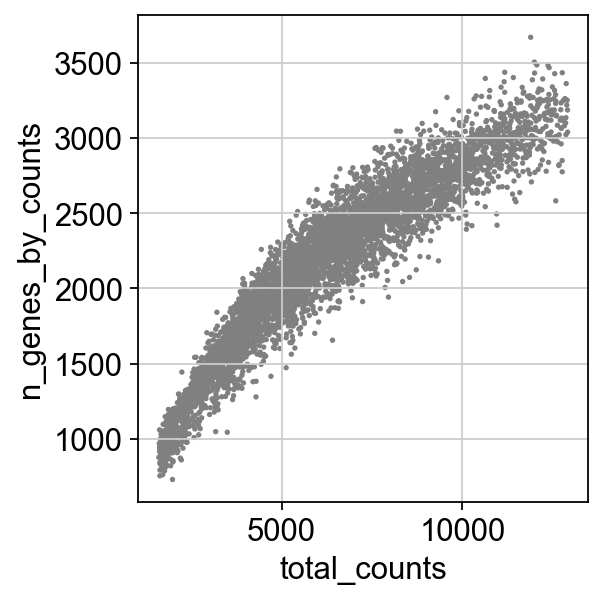

In [8]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

#### Gene filtering
We also want to exclude genes that are only detected sporadically. In this case, let's set this threshold to at least 5 cells:

In [9]:
print("Number of genes: ",adata.n_vars)
gThresh = 5

sc.pp.filter_genes(adata, min_cells=gThresh)
print("Number of genes: ",adata.n_vars)

Number of genes:  27998


Trying to set attribute `.var` of view, copying.


Number of genes:  15677


I also advocate excluding genes that are highly expressed but that are not informative. For example, the ribosomal genes, and Malat1. **Public service announcement/correction on Ribo genes**

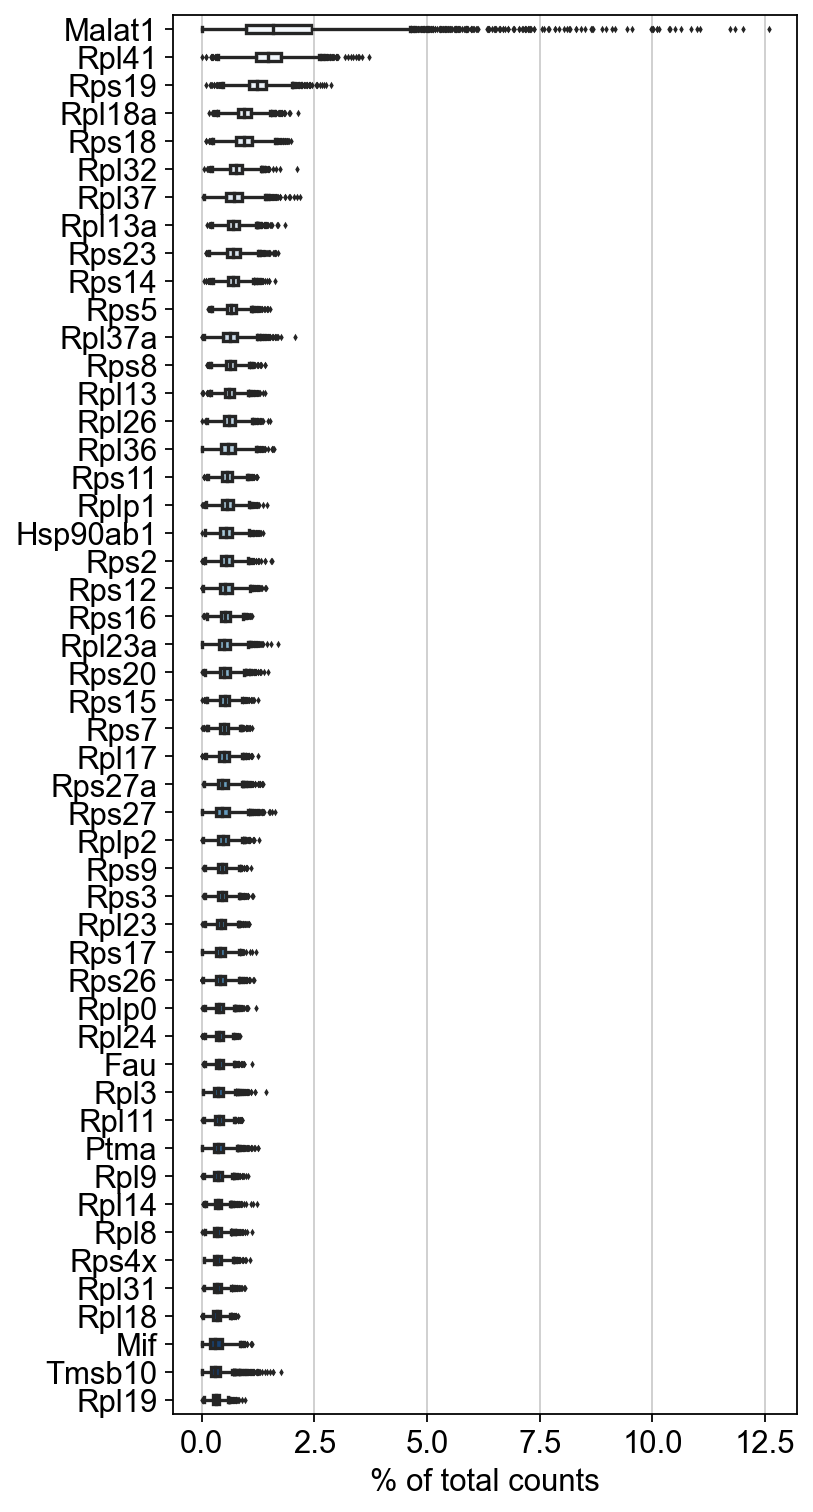

In [10]:
sc.pl.highest_expr_genes(adata, n_top=50,palette="Blues", width=.3)

In [12]:
mito_genes = adata.var_names.str.startswith('mt-')
ribo_genes = adata.var_names.str.startswith(("Rpl","Rps"))
malat_gene = adata.var_names.str.startswith("Malat1")


In [13]:
mito_genes

array([False, False, False, ..., False, False, False])

In [14]:
remove = np.add(mito_genes, ribo_genes)
remove = np.add(remove, malat_gene)

In [15]:
np.add([True, True], [False, True])

array([ True,  True])

In [19]:
keep = np.invert(remove)
keep

array([ True,  True,  True, ...,  True,  True,  True])

In [17]:
print(len(keep) - np.count_nonzero(keep))

120


In [18]:
adata = adata[:,keep].copy()
print("Number of genes: ",adata.n_vars)

Number of genes:  15557


#### Normalization
First, do a a total count normalization such that each barcode/cell ends up with the same total expression. It is also common practice to log the resulting values. BUT, lets keep a copy of the raw counts in a .raw slot:

In [21]:
adata.raw = adata
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

#### Highly variable genes
Common practice to limit some parts of analysis to those variables/genes that exhibit some degree of variation in their values across the data. We call these *highly variable genes*, or HVG for short. To find these, calculate some gene statistics, which when combined with thresholds below, determine which genes are considered HVG. These metrics are mean expression and dispersion (variance / mean). Variance is defined as the expected squared deviation of gene expression. The normalized dispersion is calculated by scaling based on a bin of mean expression. 

In [22]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=4, min_disp=0.25)
adata.var

gene_ids     mt   ribo  n_cells_by_counts  \
Xkr4            ENSMUSG00000051951  False  False                 37   
Sox17           ENSMUSG00000025902  False  False                214   
Mrpl15          ENSMUSG00000033845  False  False               3083   
Lypla1          ENSMUSG00000025903  False  False               1300   
Tcea1           ENSMUSG00000033813  False  False               2025   
...                            ...    ...    ...                ...   
Vamp7           ENSMUSG00000051412  False  False                810   
Spry3           ENSMUSG00000061654  False  False                  5   
PISD            ENSMUSG00000095041  False  False               2648   
DHRSX           ENSMUSG00000063897  False  False                363   
CAAA01147332.1  ENSMUSG00000095742  False  False                 13   

                mean_counts  pct_dropout_by_counts  total_counts  n_cells  \
Xkr4               0.007031              99.315449          38.0       36   
Sox17              0.121369              96.040703         656.0      200   
Mrpl15             1.093617              42.960222        5911.0     2812   
Lypla1             0.289732              75.948196        1566.0     1177   
Tcea1              0.507678              62.534690        2744.0     1853   
...                     ...                    ...           ...      ...   
Vamp7              0.168178              85.013876         909.0      729   
Spry3              0.000925              99.907493           5.0        5   
PISD               0.801295              51.008326        4331.0     2480   
DHRSX              0.071230              93.283996         385.0      331   
CAAA01147332.1     0.002405              99.759482          13.0       10   

                highly_variable     means  dispersions  dispersions_norm  
Xkr4                      False  0.016160     0.963224         -0.793932  
Sox17                      True  0.245262     2.410920          5.548414  
Mrpl15                    False  1.177424     1.363713          0.200615  
Lypla1                    False  0.522485     1.201372         -0.183017  
Tcea1                     False  0.782621     1.229463         -0.082616  
...                         ...       ...          ...               ...  
Vamp7                      True  0.342715     1.299276          0.339964  
Spry3                     False  0.002576     1.157724         -0.113710  
PISD                       True  1.128138     1.547616          0.890088  
DHRSX                     False  0.147803     1.127410         -0.219726  
CAAA01147332.1            False  0.006262     1.560301          1.294218  

[15557 rows x 12 columns]

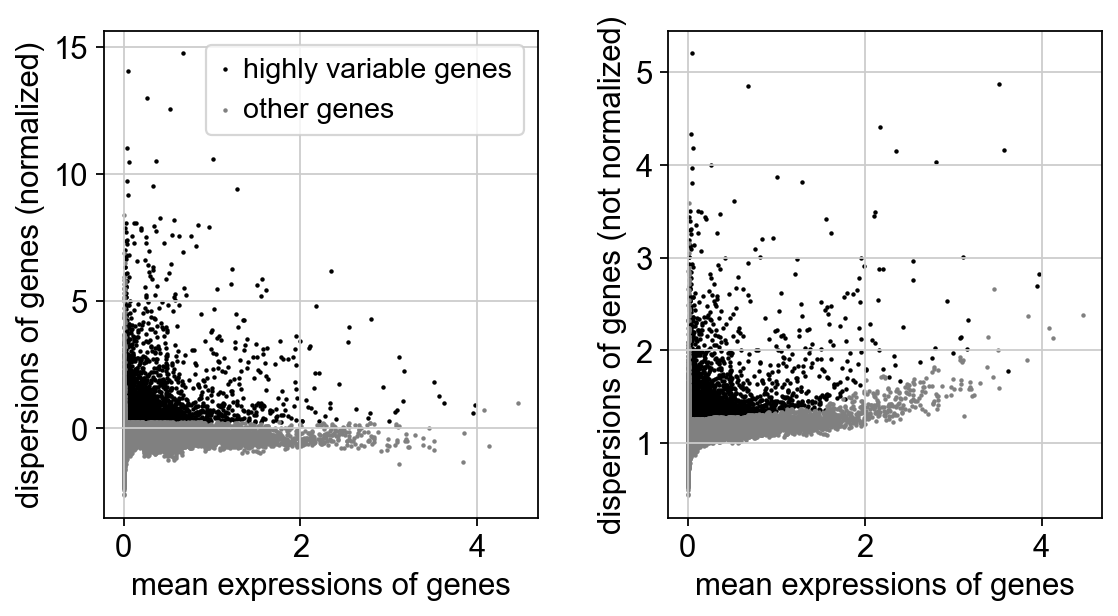

In [23]:
sc.pl.highly_variable_genes(adata)

#### Gene scaling
Often, we are more interested in *changes* in gene expression  rather than absolute expression levels, and how these changes in expression contribute to variation in cell state or cell type. To focus on this aspect of expression, we will transform expression values using the z-score, which just adjust the expression of each gene by subtracting the mean, and then dividing by the standard deviation. This is also helpful for the PCA that is performed below.

In [24]:
sc.pp.scale(adata, max_value=10)

#### Principal components analysis
There are two facts that make PCA a good tool of analzying scRNAseq data. First, genes are expressed in coordinated fashion, meaning that many have correlated expression patterns. Second scRNAseq data is noisy.

PCA allows us to reduce a high dimensional data set into a lower dimension in which much of the total variation is maintained.
To understand PCA, you need to know linear algebra. In essence, it identifies sets of linear combinations of genes in such a way that they uncorrelated and explain most variation in the data.
The function call does the following

- compute the covariance matrix (correlation between each pair of genes)
- finding eigenvectors (directions of axes that maximize that variance), orthogonal to each other

Later, we might want to select npcs = the number of pcs that will be used for downstream clustering.


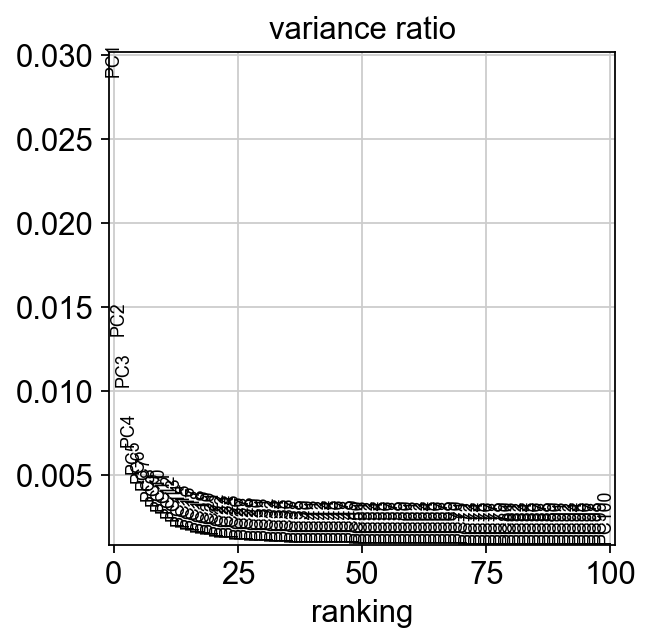

In [25]:
sc.tl.pca(adata, n_comps=100)
sc.pl.pca_variance_ratio(adata,100, )

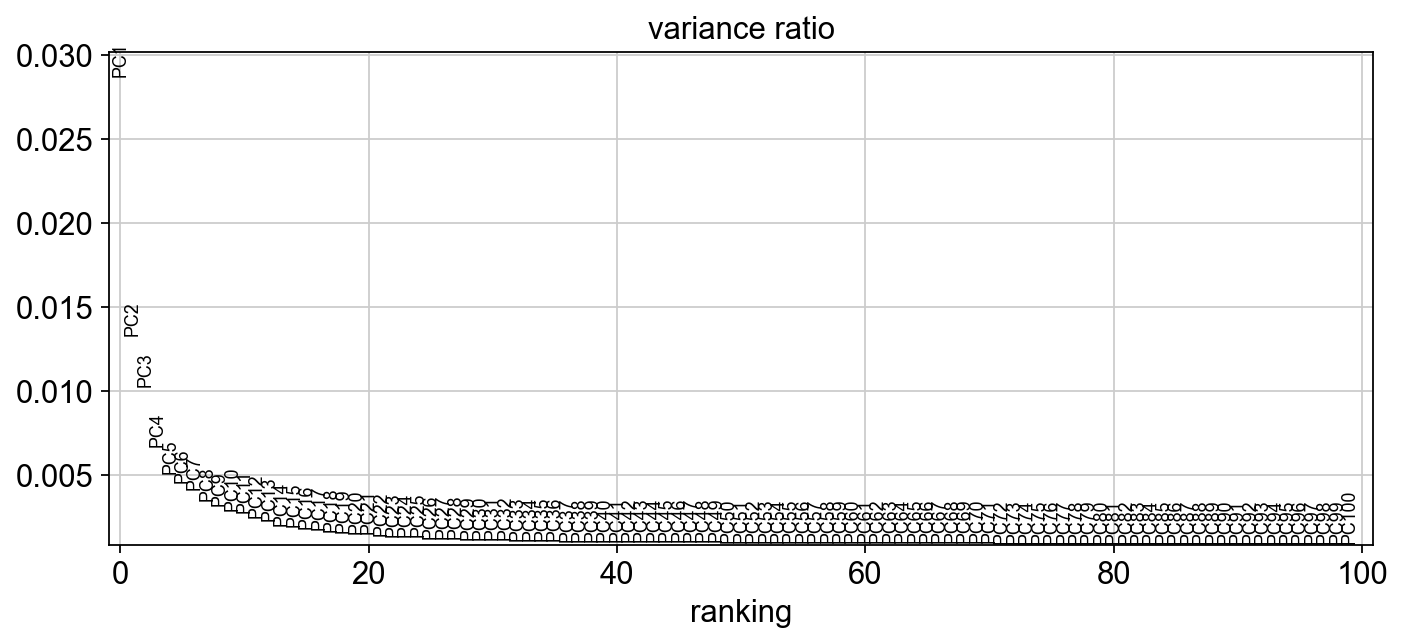

In [26]:
sc.set_figure_params(figsize="10, 4")
sc.pl.pca_variance_ratio(adata,100, )

In [27]:
np.shape(adata.obsm["X_pca"])

(5109, 100)

In [28]:
np.shape(adata.varm["PCs"])

(15557, 100)

Now, let's just take a look at how the data look! Plot the cells based on the PCs.

<AxesSubplot:xlabel='PC1', ylabel='PC4'>

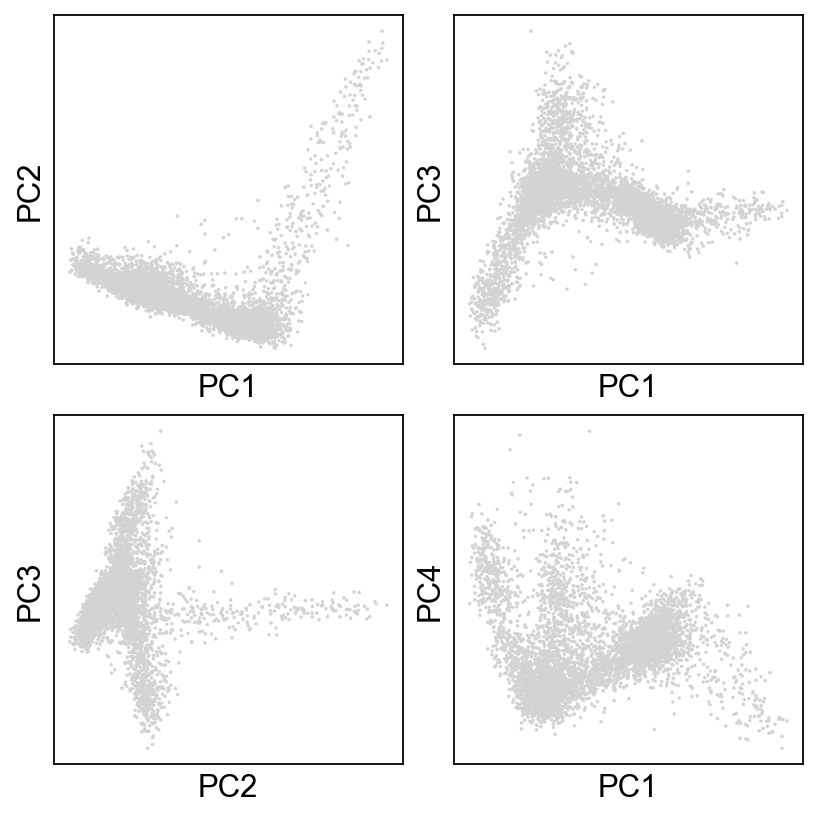

In [29]:
# sc.set_figure_params(figsize="5, 5")
fig, axs = plt.subplots(2,2, figsize=(5,5), constrained_layout=True)
sc.pl.pca_scatter(adata, ax=axs[0,0], show=False, size=10)
sc.pl.pca_scatter(adata, components="1,3", ax=axs[0,1], show=False, size=10)
sc.pl.pca_scatter(adata, components="2,3", ax=axs[1,0], show=False, size=10)
sc.pl.pca_scatter(adata, components="1,4", ax=axs[1,1], show=False, size=10)


What happens if you don't use HVG in PCA?


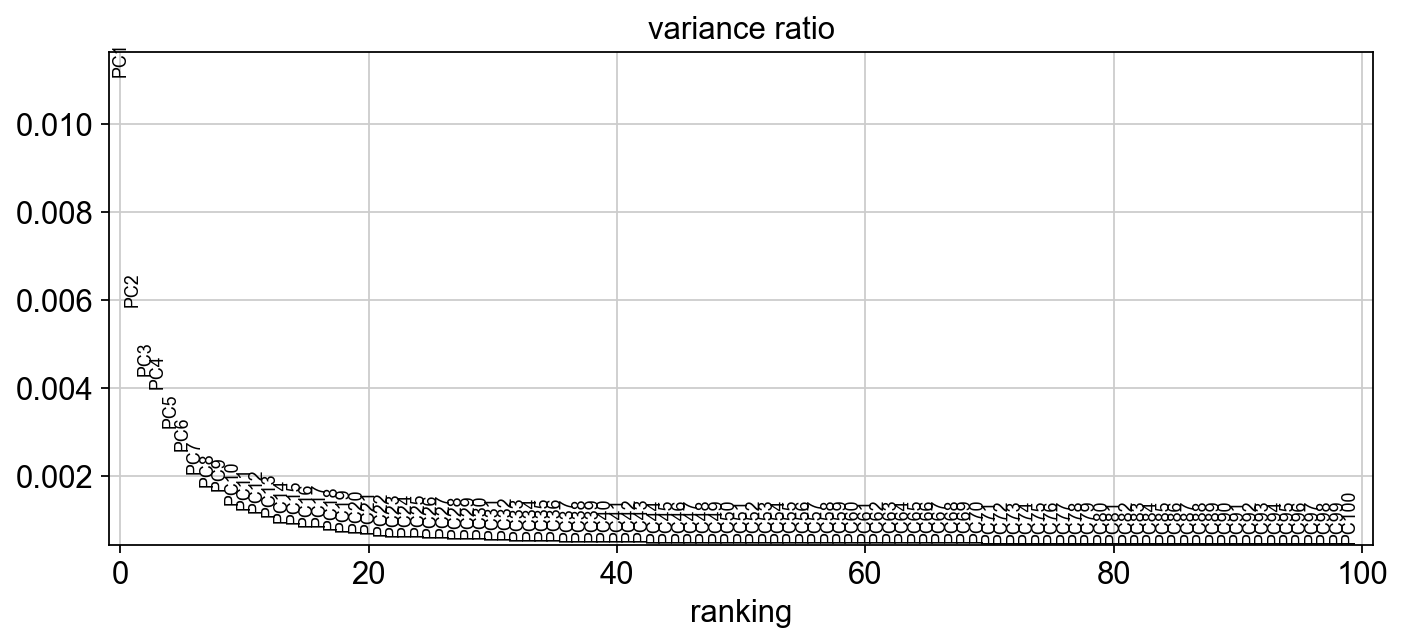

In [30]:
sc.tl.pca(adata, n_comps=100, use_highly_variable=False)
sc.set_figure_params(figsize="10, 4")
sc.pl.pca_variance_ratio(adata,100, )

<AxesSubplot:title={'center':'Zfp42'}, xlabel='PC1', ylabel='PC4'>

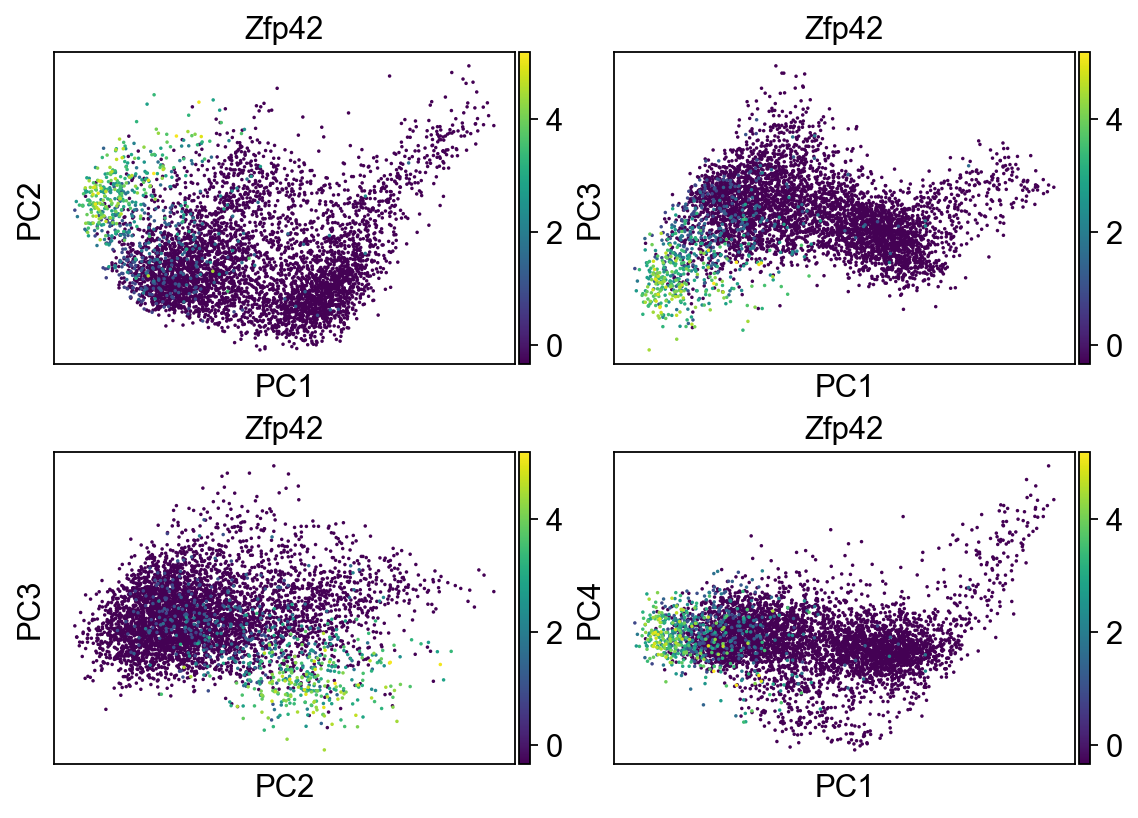

In [31]:
fig, axs = plt.subplots(2,2, figsize=(7,5), constrained_layout=True)
sc.pl.pca_scatter(adata, color="Zfp42", ax=axs[0,0], show=False, size=10, use_raw=False)
sc.pl.pca_scatter(adata, color="Zfp42", components="1,3", ax=axs[0,1], show=False, size=10, use_raw=False)
sc.pl.pca_scatter(adata, color="Zfp42", components="2,3", ax=axs[1,0], show=False, size=10, use_raw=False)
sc.pl.pca_scatter(adata, color="Zfp42", components="1,4", ax=axs[1,1], show=False, size=10, use_raw=False)

Let's go back to use the HVG

In [32]:
sc.tl.pca(adata, n_comps=100, use_highly_variable=True)

<AxesSubplot:title={'center':'Zfp42'}, xlabel='PC1', ylabel='PC4'>

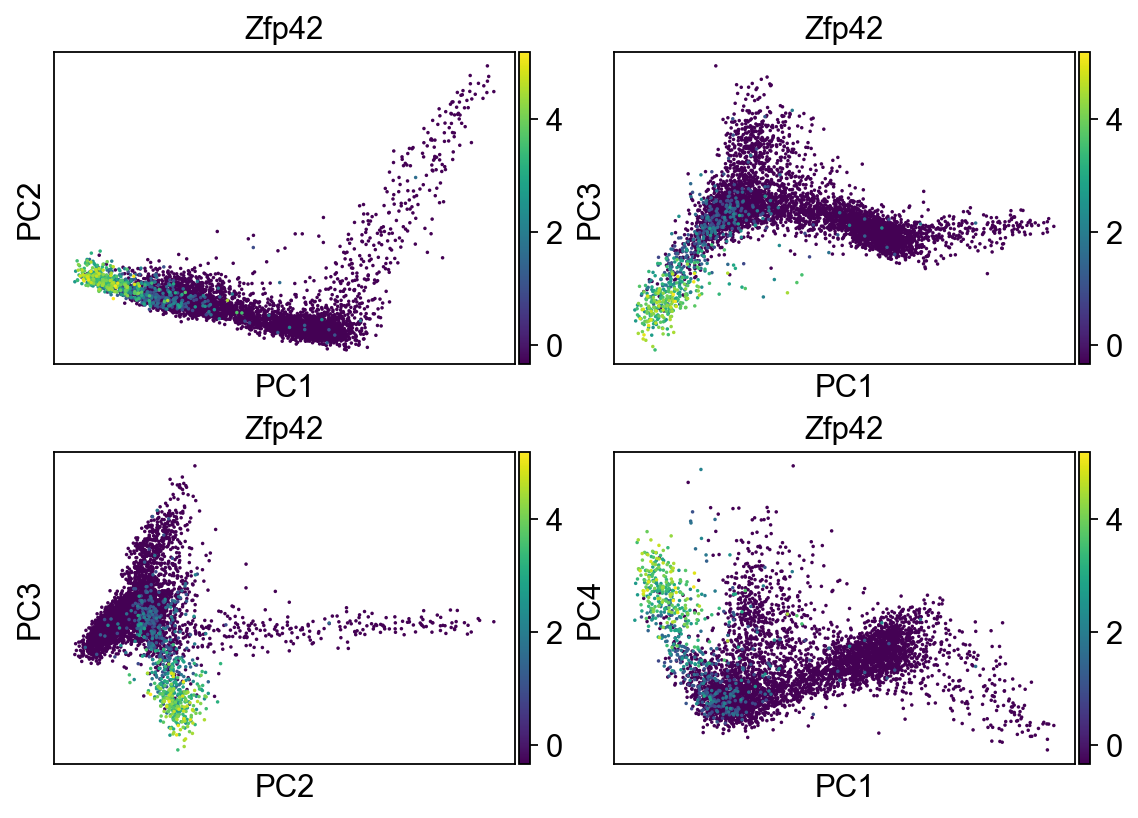

In [33]:
fig, axs = plt.subplots(2,2, figsize=(7,5), constrained_layout=True)
sc.pl.pca_scatter(adata, color="Zfp42", ax=axs[0,0], show=False, size=10, use_raw=False)
sc.pl.pca_scatter(adata, color="Zfp42", components="1,3", ax=axs[0,1], show=False, size=10, use_raw=False)
sc.pl.pca_scatter(adata, color="Zfp42", components="2,3", ax=axs[1,0], show=False, size=10, use_raw=False)
sc.pl.pca_scatter(adata, color="Zfp42", components="1,4", ax=axs[1,1], show=False, size=10, use_raw=False)

#### Cell cycle status
Recall in Lecture 5 when we covered Drop-Seq, how the authors were able to predict phase of cell cycle. What is cell cycle?

<figure>
    <img src="img/07_cell_cycle.png">
    <figcaption>Cell cycle. Credit: Wikipedia.</figcaption>
</figure>

This was done by summarizing the expression of genes associated with distinct phases of cell cycle and normalizing this value to a background value. Let's perform a similar analysis here. First, please fetch the table of mouse genes:


In [ ]:
# !wget https://compstemcellbio.s3.amazonaws.com/2022/resources/mouseCellCycle_050218.csv

In [34]:
#cell_cycle_genes = [x.strip() for x in open("/Users/pcahan/Dropbox (Personal)/data/cscb/2022/resources/mouseCellCycle_050218.csv")]
cell_cycle_genes = [x.strip() for x in open("/Users/patrickcahan/Dropbox (Personal)/data/cscb/2022/resources/mouseCellCycle_050218.csv")]


In [35]:

print("n cc genes:", len(cell_cycle_genes))
cell_cycle_genes[0:5]

n cc genes: 114


['Mcm5', 'Pcna', 'Tyms', 'Fen1', 'Mcm2']

Split into genes associated with S phase, and those associated with G2M

In [36]:
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

# now intersect these with genes present in the annData object
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
print("n cc genes:", len(cell_cycle_genes))


n cc genes: 111


In [37]:

s_genes = [x for x in s_genes if x in adata.var_names]
g2m_genes = [x for x in g2m_genes if x in adata.var_names]


In [38]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

In [39]:
adata.obs

sampleName  n_genes_by_counts  total_counts  \
AAACATACCCTACC-1   mEB_day4               1212        2238.0   
AAACATACGTCGTA-1   mEB_day4               1588        3831.0   
AAACATACTTTCAC-1   mEB_day4               1538        3381.0   
AAACATTGCATTGG-1   mEB_day4               1221        2489.0   
AAACATTGCTTGCC-1   mEB_day4               2661        9510.0   
...                     ...                ...           ...   
TTTGACTGACTCTT-1   mEB_day4               2941       11419.0   
TTTGACTGAGGCGA-1   mEB_day4               2446        6908.0   
TTTGACTGCATTGG-1   mEB_day4               2906        9558.0   
TTTGACTGCTGGAT-1   mEB_day4               1475        3280.0   
TTTGACTGGTGAGG-1   mEB_day4               2808        9123.0   

                  total_counts_ribo  pct_counts_ribo  total_counts_mt  \
AAACATACCCTACC-1              629.0        28.105453             28.0   
AAACATACGTCGTA-1             1267.0        33.072304             34.0   
AAACATACTTTCAC-1              961.0        28.423544              2.0   
AAACATTGCATTGG-1              750.0        30.132584             24.0   
AAACATTGCTTGCC-1             3132.0        32.933754             71.0   
...                             ...              ...              ...   
TTTGACTGACTCTT-1             4406.0        38.584812             44.0   
TTTGACTGAGGCGA-1             1999.0        28.937466             65.0   
TTTGACTGCATTGG-1             3067.0        32.088303             91.0   
TTTGACTGCTGGAT-1             1035.0        31.554878             22.0   
TTTGACTGGTGAGG-1             2923.0        32.039898             55.0   

                  pct_counts_mt   S_score  G2M_score phase  
AAACATACCCTACC-1       1.251117 -0.025818   0.066043   G2M  
AAACATACGTCGTA-1       0.887497  0.193831   0.545027   G2M  
AAACATACTTTCAC-1       0.059154  0.453981   0.562032   G2M  
AAACATTGCATTGG-1       0.964243  0.001577   0.840160   G2M  
AAACATTGCTTGCC-1       0.746583  0.446344   0.671123   G2M  
...                         ...       ...        ...   ...  
TTTGACTGACTCTT-1       0.385323 -0.164811   0.345561   G2M  
TTTGACTGAGGCGA-1       0.940938  0.704966   0.669519     S  
TTTGACTGCATTGG-1       0.952082  1.178114   0.898342     S  
TTTGACTGCTGGAT-1       0.670732  0.246748   0.693743   G2M  
TTTGACTGGTGAGG-1       0.602872 -0.162199   1.935829   G2M  

[5109 rows x 10 columns]

In [40]:
adata_cc_genes = adata[:, cell_cycle_genes].copy()
sc.pp.pca(adata_cc_genes,use_highly_variable=False)


... storing 'phase' as categorical


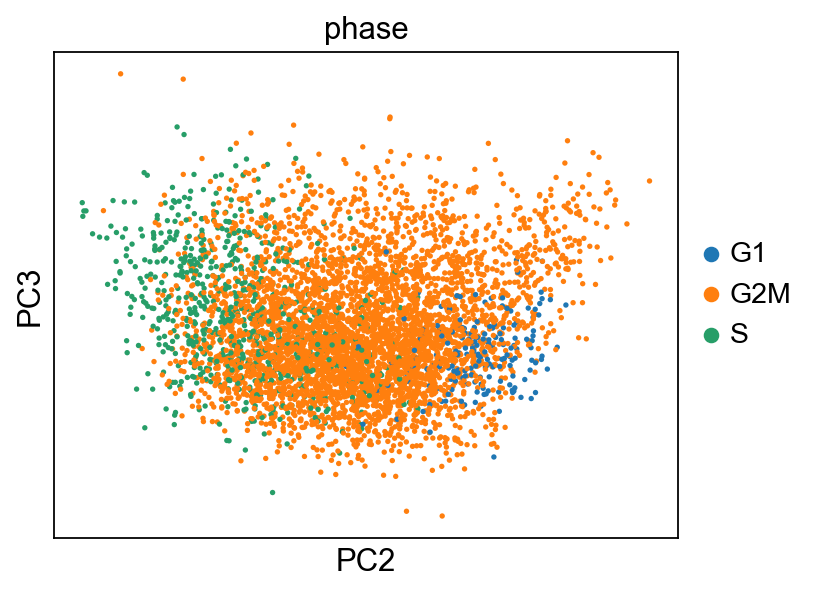

In [41]:
sc.set_figure_params(figsize="5, 4")
sc.pl.pca_scatter(adata_cc_genes, color=["phase"], components="2,3")


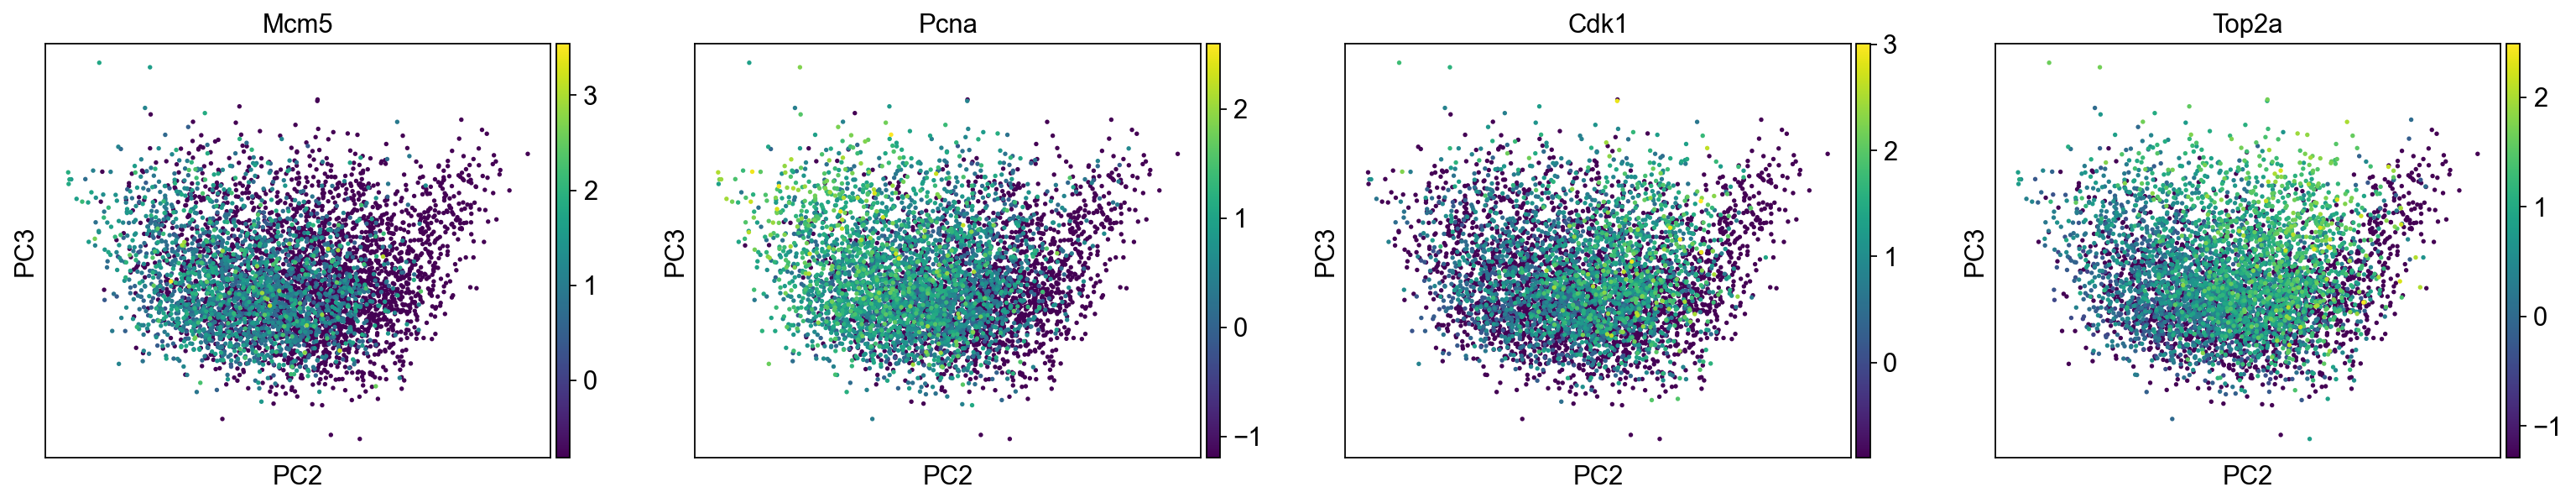

In [42]:
sc.pl.pca_scatter(adata_cc_genes, color=("Mcm5", "Pcna", "Cdk1", "Top2a"), components="2,3", use_raw=False)

... storing 'phase' as categorical


<AxesSubplot:title={'center':'phase'}, xlabel='PC1', ylabel='PC4'>

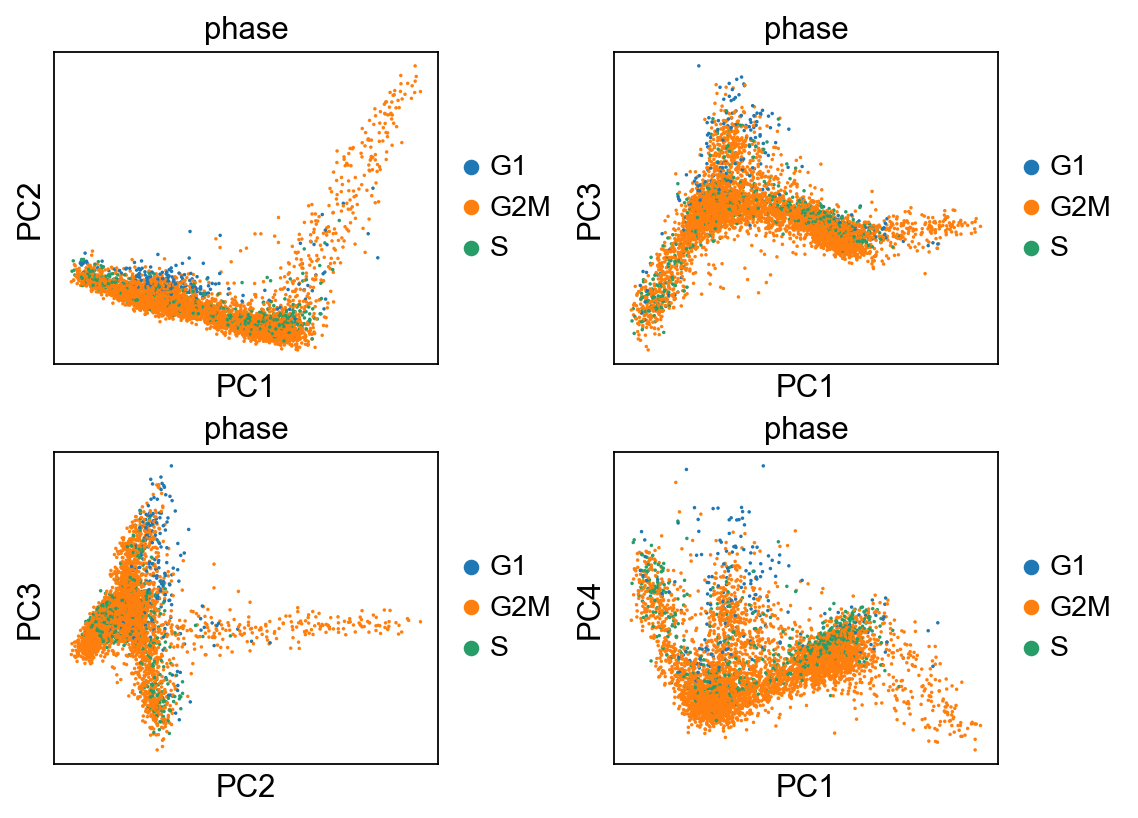

In [43]:
fig, axs = plt.subplots(2,2, figsize=(7,5), constrained_layout=True)
sc.pl.pca_scatter(adata, color="phase", ax=axs[0,0], show=False, size=10)
sc.pl.pca_scatter(adata, color="phase", components="1,3", ax=axs[0,1], show=False, size=10)
sc.pl.pca_scatter(adata, color="phase", components="2,3", ax=axs[1,0], show=False, size=10)
sc.pl.pca_scatter(adata, color="phase", components="1,4", ax=axs[1,1], show=False, size=10)

<AxesSubplot:title={'center':'total_counts'}, xlabel='PC1', ylabel='PC4'>

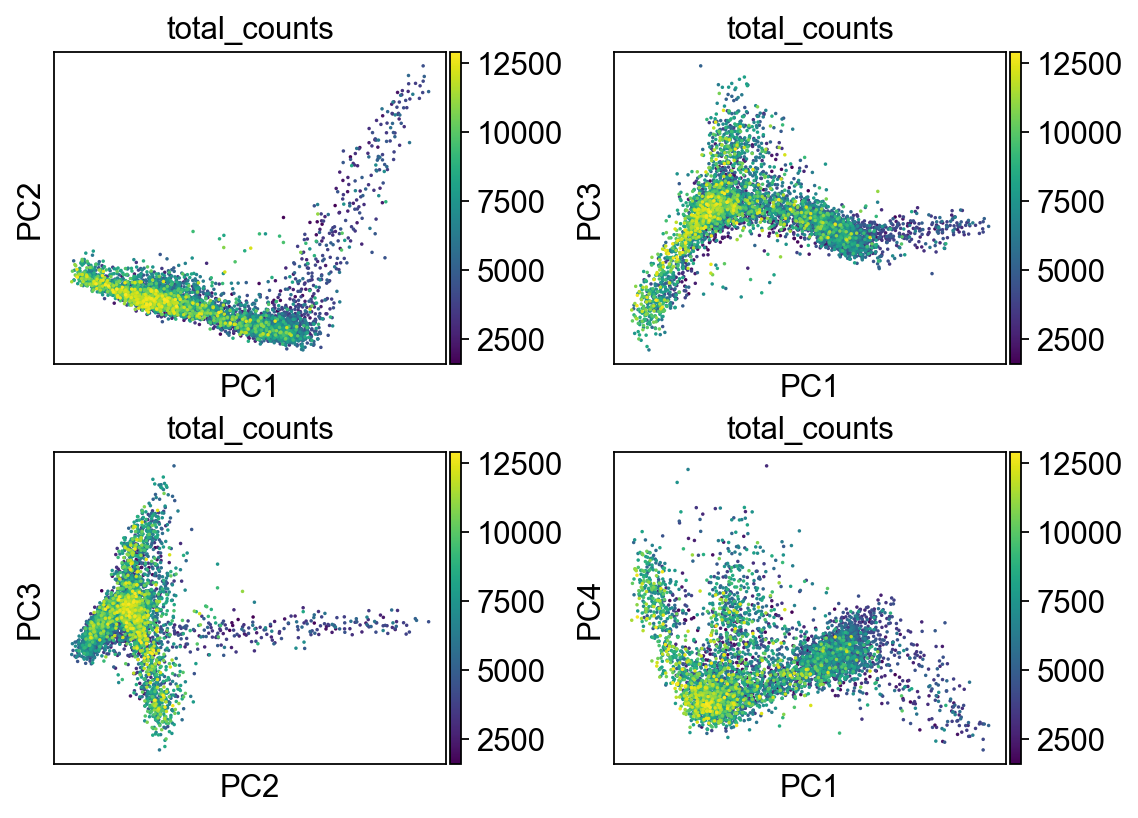

In [44]:
fig, axs = plt.subplots(2,2, figsize=(7,5), constrained_layout=True)
sc.pl.pca_scatter(adata, color="total_counts", ax=axs[0,0], show=False, size=10)
sc.pl.pca_scatter(adata, color="total_counts", components="1,3", ax=axs[0,1], show=False, size=10)
sc.pl.pca_scatter(adata, color="total_counts", components="2,3", ax=axs[1,0], show=False, size=10)
sc.pl.pca_scatter(adata, color="total_counts", components="1,4", ax=axs[1,1], show=False, size=10)

#### Clustering
Let's start with one of the simplest clustering methods: k-means. It is an iterative process that starts with k randomly sampled points. It assigns cells to cluster defined by the nearest point. Then, it updates the points as the center of the newly defined cluster, repeating this process unitl convergence or a specified number of times. The key concept here is that of the distance metric, which quantifies how close cells are. Eucliean distance is commonly used, as are different transformations of correlation measures (e.g. 1 - PCC).



In [45]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [46]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(adata.obsm["X_pca"])
adata.obs['kmeans2'] = kmeans.labels_.astype(str)

... storing 'kmeans2' as categorical


<AxesSubplot:title={'center':'kmeans2'}, xlabel='PC1', ylabel='PC4'>

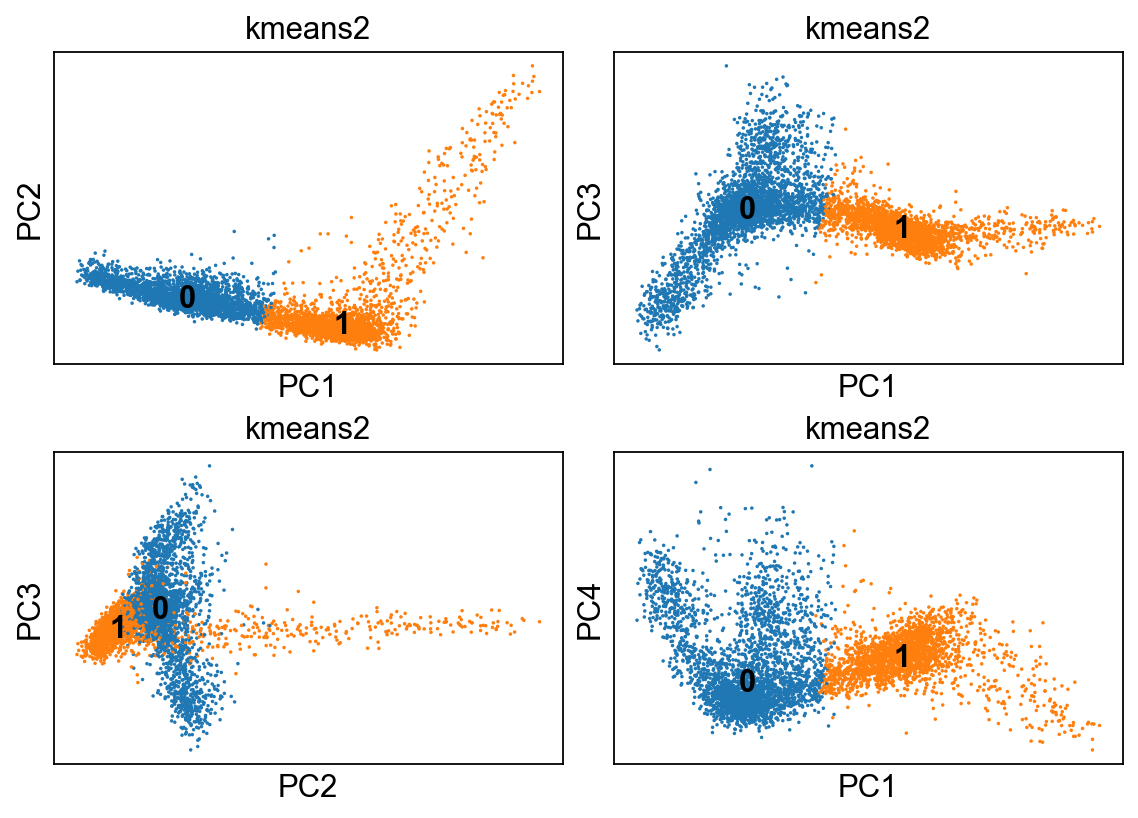

In [47]:
fig, axs = plt.subplots(2,2, figsize=(7,5), constrained_layout=True)
sc.pl.pca_scatter(adata, color="kmeans2", ax=axs[0,0], show=False, size=10, use_raw=False, legend_loc="on data")
sc.pl.pca_scatter(adata, color="kmeans2", components="1,3", ax=axs[0,1], show=False, size=10, use_raw=False, legend_loc="on data")
sc.pl.pca_scatter(adata, color="kmeans2", components="2,3", ax=axs[1,0], show=False, size=10, use_raw=False, legend_loc="on data")
sc.pl.pca_scatter(adata, color="kmeans2", components="1,4", ax=axs[1,1], show=False, size=10, use_raw=False, legend_loc="on data")

... storing 'kmeans10' as categorical


<AxesSubplot:title={'center':'kmeans10'}, xlabel='PC1', ylabel='PC4'>

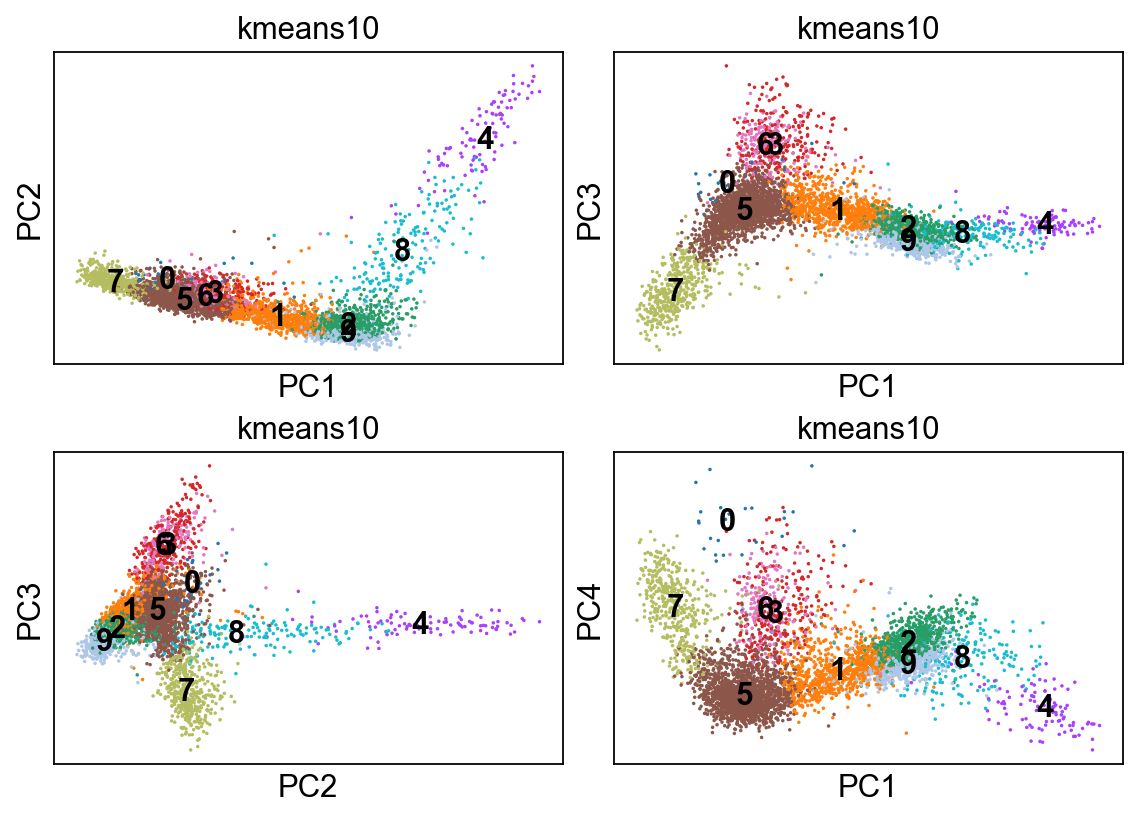

In [48]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(adata.obsm["X_pca"])
adata.obs['kmeans10'] = kmeans.labels_.astype(str)

fig, axs = plt.subplots(2,2, figsize=(7,5), constrained_layout=True)
sc.pl.pca_scatter(adata, color="kmeans10", ax=axs[0,0], show=False, size=10, use_raw=False, legend_loc="on data")
sc.pl.pca_scatter(adata, color="kmeans10", components="1,3", ax=axs[0,1], show=False, size=10, use_raw=False, legend_loc="on data")
sc.pl.pca_scatter(adata, color="kmeans10", components="2,3", ax=axs[1,0], show=False, size=10, use_raw=False, legend_loc="on data")
sc.pl.pca_scatter(adata, color="kmeans10", components="1,4", ax=axs[1,1], show=False, size=10, use_raw=False, legend_loc="on data")

In [49]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(adata.obsm["X_pca"])
adata.obs['kmeans5'] = kmeans.labels_.astype(str)


... storing 'kmeans5' as categorical


<AxesSubplot:title={'center':'kmeans5'}, xlabel='PC1', ylabel='PC4'>

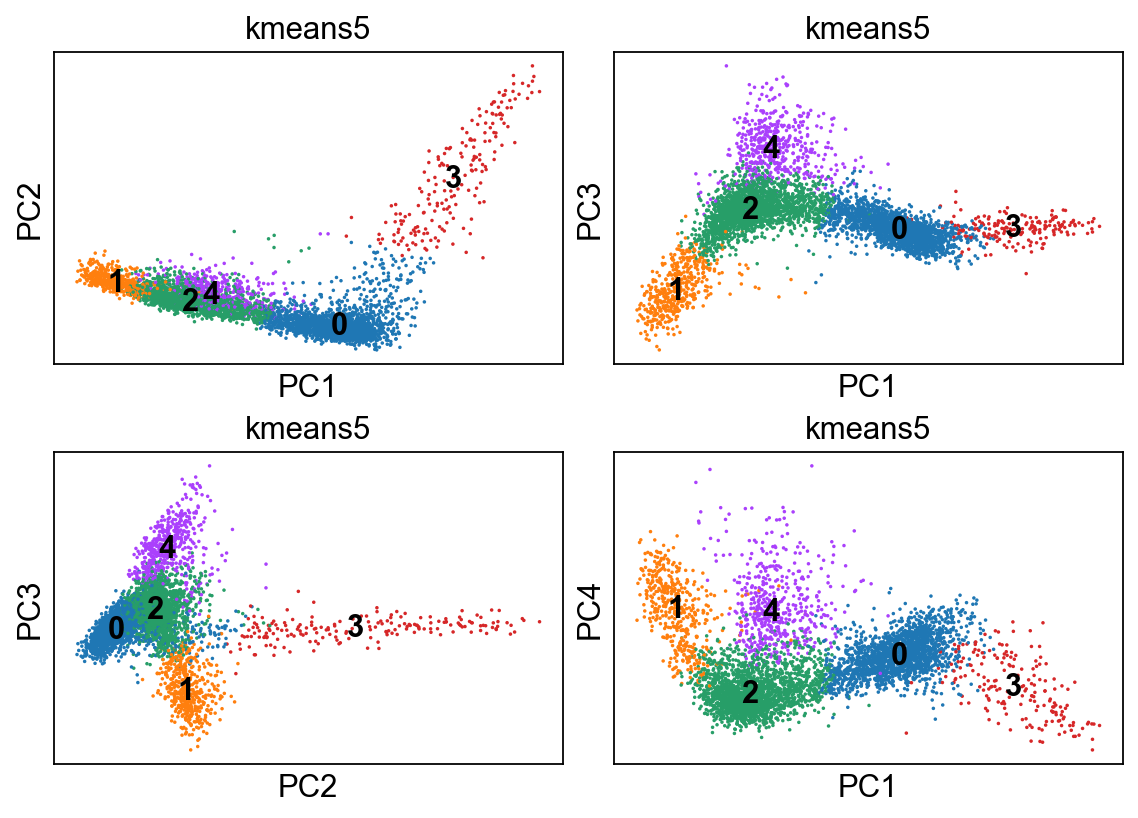

In [50]:

fig, axs = plt.subplots(2,2, figsize=(7,5), constrained_layout=True)
sc.pl.pca_scatter(adata, color="kmeans5", ax=axs[0,0], show=False, size=10, use_raw=False, legend_loc="on data")
sc.pl.pca_scatter(adata, color="kmeans5", components="1,3", ax=axs[0,1], show=False, size=10, use_raw=False, legend_loc="on data")
sc.pl.pca_scatter(adata, color="kmeans5", components="2,3", ax=axs[1,0], show=False, size=10, use_raw=False, legend_loc="on data")
sc.pl.pca_scatter(adata, color="kmeans5", components="1,4", ax=axs[1,1], show=False, size=10, use_raw=False, legend_loc="on data")

Now let's try another simple method: hierarchical clustering. *describe this method*



In [51]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
adata.obs['hclust_2'] = cluster.fit_predict(adata.obsm["X_pca"]).astype(str)

cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
adata.obs['hclust_3'] = cluster.fit_predict(adata.obsm["X_pca"]).astype(str)

cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
adata.obs['hclust_5'] = cluster.fit_predict(adata.obsm["X_pca"]).astype(str)

cluster = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='ward')
adata.obs['hclust_10'] = cluster.fit_predict(adata.obsm["X_pca"]).astype(str)



... storing 'hclust_2' as categorical
... storing 'hclust_3' as categorical
... storing 'hclust_5' as categorical
... storing 'hclust_10' as categorical


<AxesSubplot:title={'center':'hclust_10'}, xlabel='PC1', ylabel='PC3'>

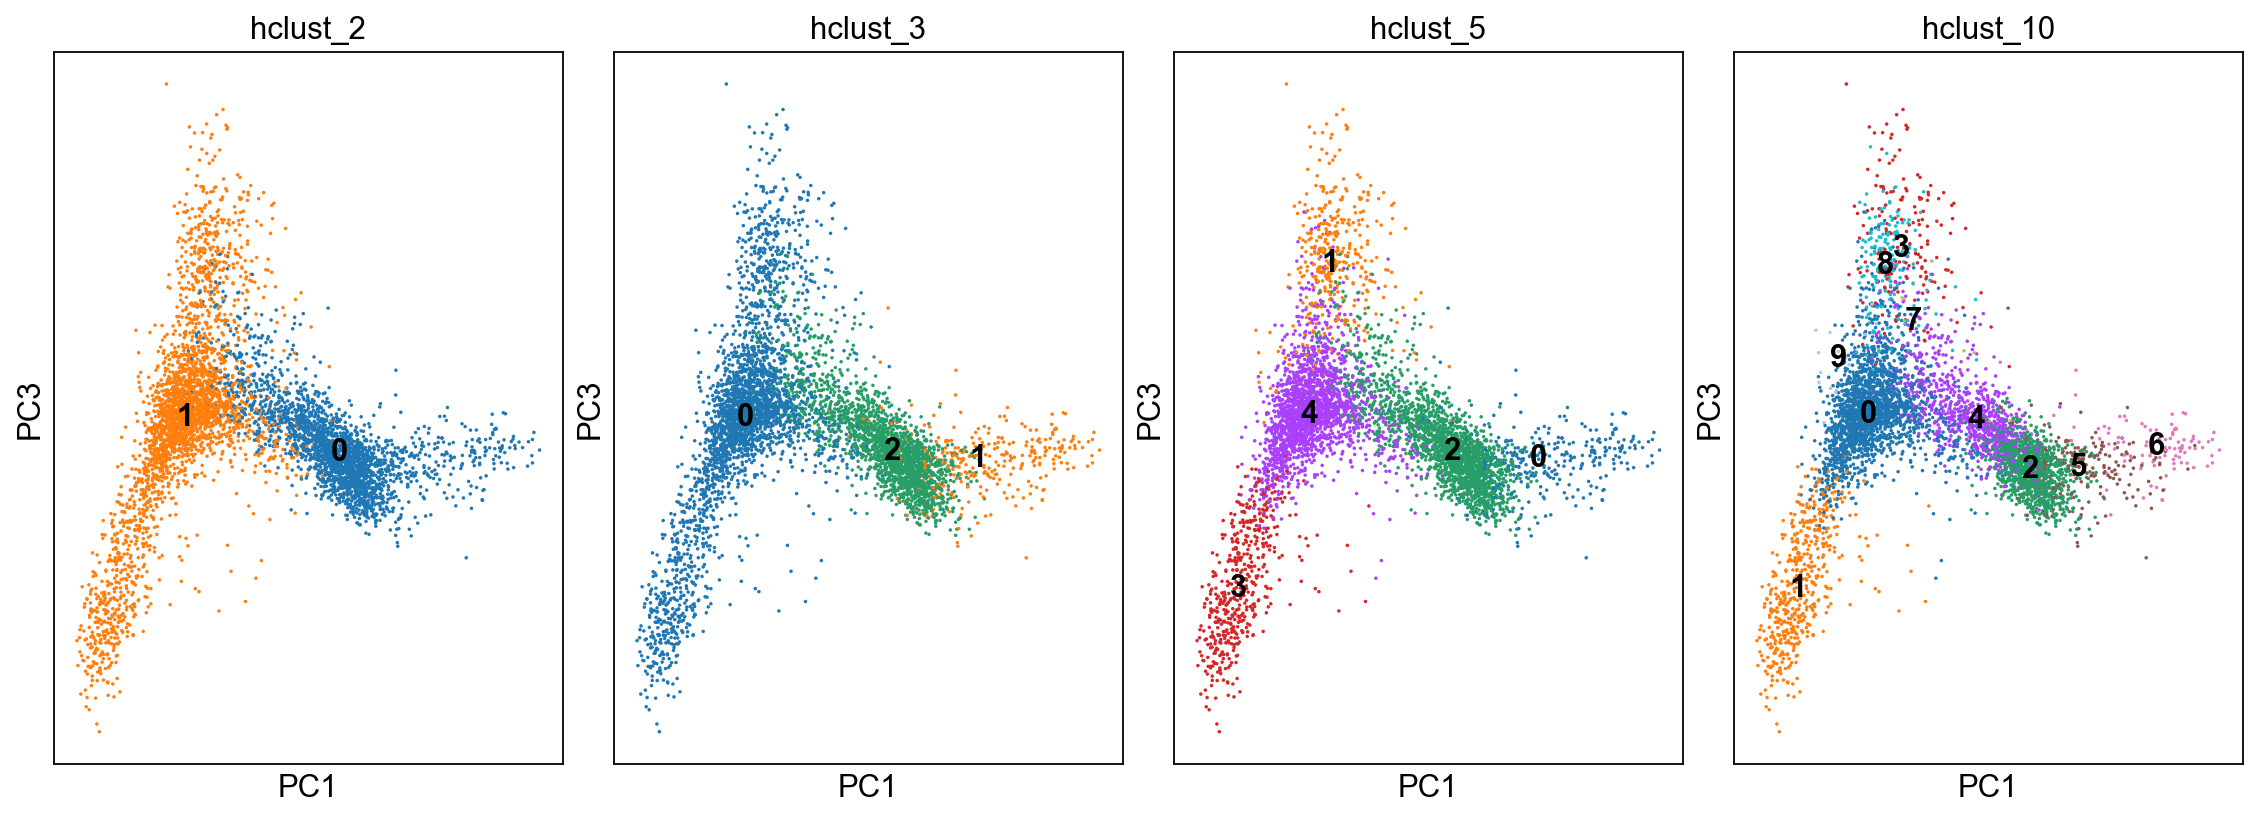

In [52]:
fig, axs = plt.subplots(1,4, figsize=(14,5), constrained_layout=True)
sc.pl.pca_scatter(adata, color="hclust_2", components="1,3",ax=axs[0], show=False, size=10, use_raw=False, legend_loc="on data")
sc.pl.pca_scatter(adata, color="hclust_3", components="1,3",ax=axs[1], show=False, size=10, use_raw=False, legend_loc="on data")
sc.pl.pca_scatter(adata, color="hclust_5", components="1,3",ax=axs[2], show=False, size=10, use_raw=False, legend_loc="on data")
sc.pl.pca_scatter(adata, color="hclust_10", components="1,3",ax=axs[3], show=False, size=10, use_raw=False, legend_loc="on data")


One final class of clustering methods is based on deriving the k-nearest neighbor graph. *Walk them through the concept*, explain how used to transform adjacency matrix


<figure>
    <img src="img/07_knn_graph_1.png">
    <figcaption>K-nearest neighbor graph. Credit: Wikipedia.</figcaption>
</figure>

Recall the elbow plot. From this, we can pick out a reasonable n_pcs



In [53]:
n_pcs = 20 
n_neighbors = 15
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [54]:
sc.tl.leiden(adata, .25)




<AxesSubplot:title={'center':'leiden'}, xlabel='PC1', ylabel='PC3'>

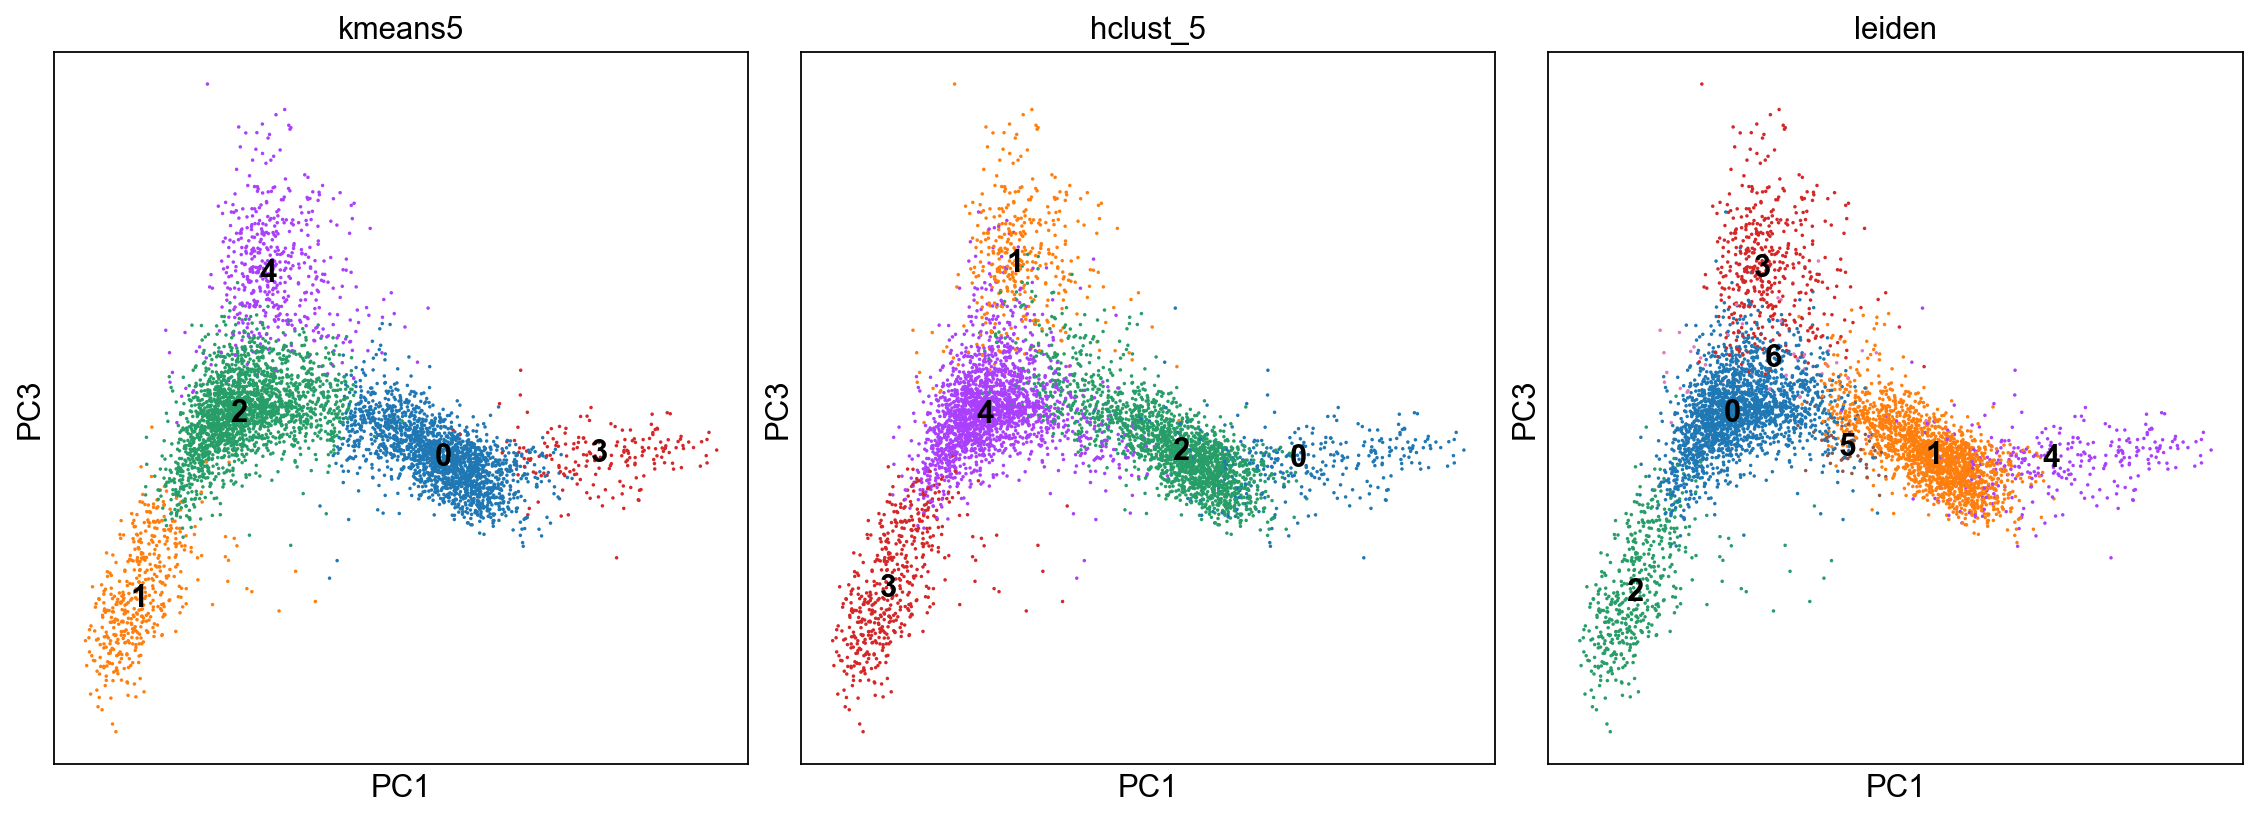

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(14,5), constrained_layout=True)
sc.pl.pca_scatter(adata, color="kmeans5", components="1,3",ax=axs[0], show=False, size=10, use_raw=False, legend_loc="on data")
sc.pl.pca_scatter(adata, color="hclust_5", components="1,3",ax=axs[1], show=False, size=10, use_raw=False, legend_loc="on data")
sc.pl.pca_scatter(adata, color="leiden", components="1,3",ax=axs[2], show=False, size=10, use_raw=False, legend_loc="on data")

We only got to this point in the class. Below are two lines of code that 
1.) perform a t-test to identify differentially expressed genes between clusters. It does this in by comparing mean expression of genes in each cluster vs all other clusters.
2.) ranking the genes according to their differential expression per cluster, and producing a dot plot of the top 5 genes per cluster.

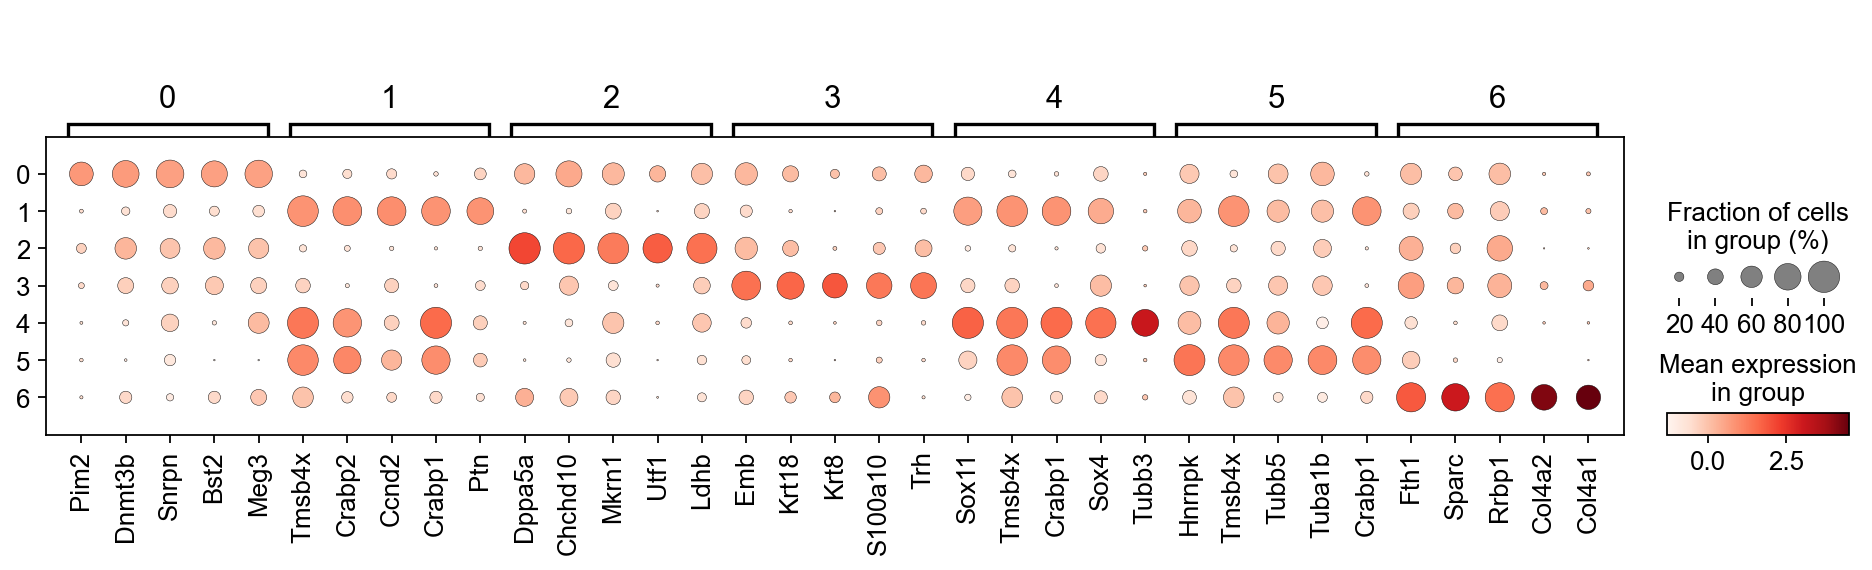

In [56]:
sc.tl.rank_genes_groups(adata,'leiden', use_raw=False)
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, groupby='leiden', use_raw=False, dendrogram=False)


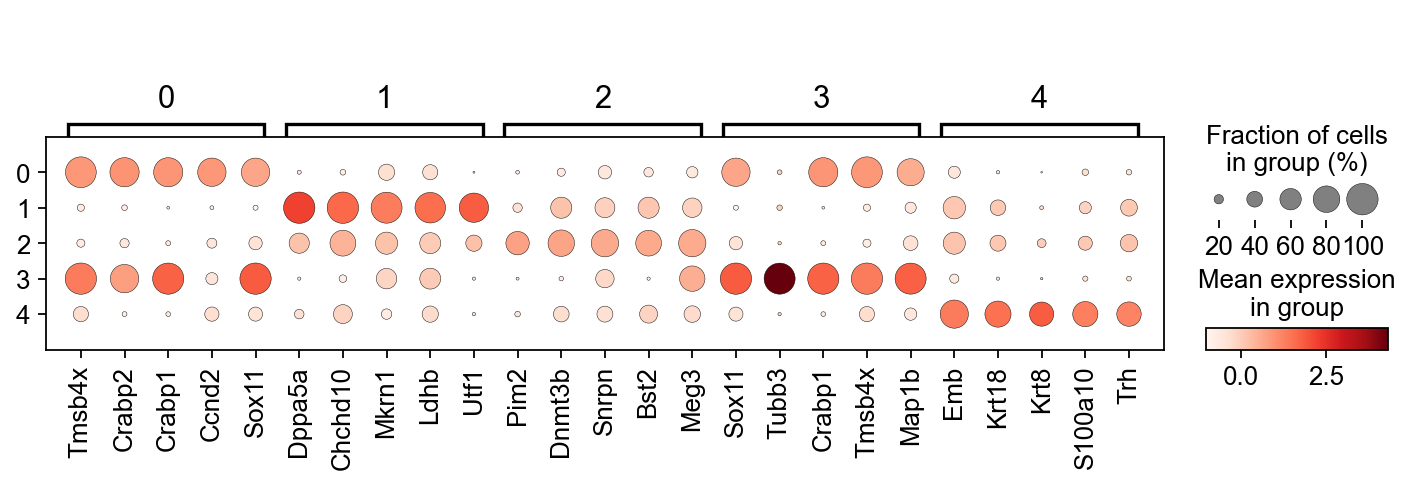

In [57]:
sc.tl.rank_genes_groups(adata,'kmeans5', use_raw=False)
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, groupby='kmeans5', use_raw=False, dendrogram=False)
